In [434]:
import pathlib
import random
import pandas as pd
import numpy as np
import sys
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style='darkgrid')

from sklearn.metrics import (
    f1_score, 
    accuracy_score,
    classification_report, 
)

ROOT_DIR = pathlib.Path().absolute()
DATA_DIR = ROOT_DIR / "data"
RANDOM_SEED = 42

## Загрузка и обзор данных

In [435]:
df_trends = pd.read_csv(DATA_DIR / "trends_description.csv")
df = pd.read_csv(DATA_DIR / "train.csv")
df_test = pd.read_csv(DATA_DIR / "test.csv")
df_test_copy=df_test.copy()


In [436]:
for i in range(50):
    df.rename(columns={f"trend_id_res{i}": i}, inplace=True)
#df["labels"] = df.drop('index',axis=1).drop('assessment',axis=1).drop('tags',axis=1).drop('text',axis=1).drop('Unnamed: 0',axis=1).apply(lambda r: r.index[r.ne(0)].to_list(), axis=1)
df.head()

,Unnamed: 0,index,assessment,tags,text,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}","Можно немного скинуть минимальную сумму заказа или оплачивать доставку ,если сумма меньше,как в Яндекс маркете",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Обучение моделей

### Предобработка данных

In [437]:
df.head()

,Unnamed: 0,index,assessment,tags,text,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}","Можно немного скинуть минимальную сумму заказа или оплачивать доставку ,если сумма меньше,как в Яндекс маркете",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [438]:
df.drop(columns=['index','Unnamed: 0', 'assessment'],axis=1, inplace=True)
df.head()

,tags,text,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"{PRICE,PROMOTIONS}","Можно немного скинуть минимальную сумму заказа или оплачивать доставку ,если сумма меньше,как в Яндекс маркете",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [439]:


X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, :2], df.iloc[:, 2:], test_size=0.01, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)



(4576, 2) (47, 2) (4576, 50) (47, 50)


In [440]:
X_train.head()

,tags,text
2154,"{SUPPORT,DELIVERY}",Медленные курьеры дорогие товары
1292,"{ASSORTMENT,PROMOTIONS,PRICE}","Периодически вы офигеваете с минимальной ценой заказа, серьёзно"
3985,{DELIVERY},Заказ не может приехать уже [NUM] минут!
2174,"{ASSORTMENT,PRODUCTS_QUALITY,DELIVERY,SUPPORT}","Часто опаздывают курьеры, рассчитываю на один заказ - могут убрать что-то из заказа и даже не позвонить, не предложить замену"
2638,{PRICE},Резкие перепады цен


In [441]:
def preprocess_text(data):
  data = data['text'] 

  tfidf_vectorizer = TfidfVectorizer(max_features=3)
  data_vectorized = tfidf_vectorizer.fit_transform(data)
  return data_vectorized


In [442]:


X_train = preprocess_text(X_train)
X_val = preprocess_text(X_val)
print(X_train.shape, X_val.shape)
df_test.head()



(4576, 3) (47, 3)


,Unnamed: 0,index,assessment,tags,text
0,1,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов"
1,3,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции
2,5,22118,2.0,"{CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}","Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут"
3,7,23511,0.0,{DELIVERY},Ужасно долгая доставка
4,8,45,6.0,"{ASSORTMENT,PROMOTIONS}",Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.


In [443]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_shape = X_train.shape[1]
num_labels = y_train.shape[1]

# model architecture
model = Sequential([
    Dense(512, input_shape=(input_shape,), activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_labels, activation='sigmoid')
])

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# model summary
model.summary() 

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 512)               2048      
                                                                 
 dropout_28 (Dropout)        (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 128)               65664     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 50)                6450      
                                                                 
Total params: 74,162
Trainable params: 74,162
Non-trainable params: 0
_________________________________________________________________


In [444]:
history = model.fit(X_train.toarray(), y_train.values, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
115/115 [==============================] - 2s 7ms/step - loss: 0.6510 - accuracy: 0.0156 - val_loss: 0.5612 - val_accuracy: 0.0066
Epoch 2/100
115/115 [==============================] - 1s 5ms/step - loss: 0.3932 - accuracy: 0.0115 - val_loss: 0.2341 - val_accuracy: 0.0066
Epoch 3/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1789 - accuracy: 0.0743 - val_loss: 0.1471 - val_accuracy: 0.1714
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1363 - accuracy: 0.1544 - val_loss: 0.1297 - val_accuracy: 0.1801
Epoch 5/100
115/115 [==============================] - 1s 4ms/step - loss: 0.1247 - accuracy: 0.1672 - val_loss: 0.1224 - val_accuracy: 0.1932
Epoch 6/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1192 - accuracy: 0.1738 - val_loss: 0.1180 - val_accuracy: 0.2052
Epoch 7/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1157 - accuracy: 0.1781 - val_loss: 0.1152 - val_accuracy: 0.2052

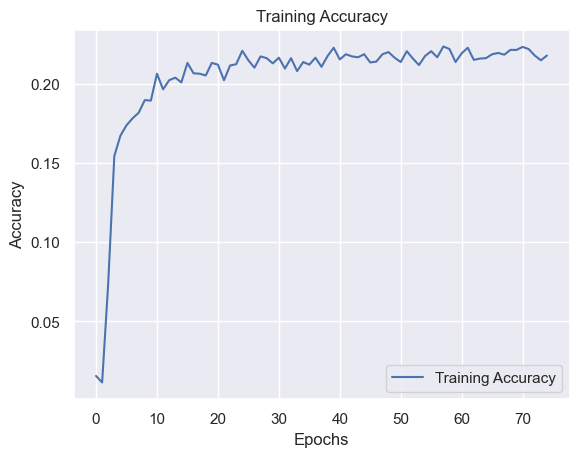

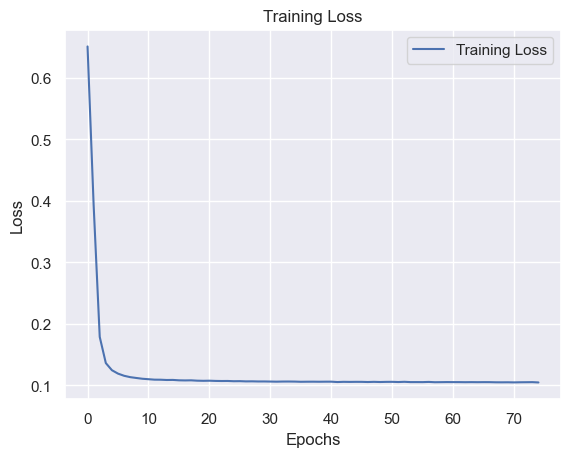

In [445]:


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [446]:
test_loss, test_accuracy = model.evaluate(X_val.toarray(), y_val.values)
print(f'Test Accuracy= {round(test_accuracy,2)*100}%\nTest Loss= {round(test_loss,2)}')

2/2 [==============================] - 0s 5ms/step - loss: 0.0926 - accuracy: 0.2979
Test Accuracy= 30.0%
Test Loss= 0.09


In [447]:


df_test.drop(columns=['index', 'Unnamed: 0', 'assessment', 'tags'], axis=1, inplace=True)
df_test.head()



,text
0,"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов"
1,Цены намного выше магазинных но радуют акции
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут"
3,Ужасно долгая доставка
4,Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.


In [448]:
df_test = df_test.fillna('')
df_test = df_test.replace('', 'хорошо')
df_test.isnull().sum()

text    0
dtype: int64

In [453]:
predict = preprocess_text(df_test)
predict.shape

(9015, 3)

In [454]:
pred=model.predict(predict.toarray())
print(pred)

282/282 [==============================] - 1s 2ms/step
[[0.13601957 0.08940599 0.40622416 ... 0.00932086 0.00475195 0.00347019]
 [0.12154768 0.0398375  0.02251948 ... 0.00584611 0.00620285 0.00118213]
 [0.23614115 0.1660139  0.52689314 ... 0.00554108 0.00255993 0.00171511]
 ...
 [0.08521753 0.02887881 0.05943399 ... 0.01444982 0.01191576 0.00765923]
 [0.12154767 0.0398375  0.02251948 ... 0.00584611 0.00620285 0.00118213]
 [0.14325342 0.1003847  0.44443637 ... 0.00708031 0.00345017 0.00221109]]


In [456]:
predictions = model.predict(predict.toarray())

predicted_labels = (predictions >= 0.15).astype(int)
class_mapping={}
for i in range(50):
    class_mapping[i]=f'{i}'


results = df_test.copy()


def get_predicted_classes(label_vector):
    return ', '.join([class_mapping[i] for i, val in enumerate(label_vector) if val == 1])

results['t'] = [get_predicted_classes(label) for label in predicted_labels]

pd.set_option('display.max_colwidth', None)

multi_label_rows = results[results['t'].str.contains(',')]
multi_label_rows.head(5)




282/282 [==============================] - 1s 2ms/step


,text,t
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут","0, 1, 2"
3,Ужасно долгая доставка,"0, 1"
5,Хотелось бы быструю доставку. Заказ доставляют от [NUM] минут до [NUM] часа. Часто привозят гнилые овощи фрукты,"0, 2"
9,"Все хорошо, если бы еще доставка была быстрее, цены бы не было!","0, 2, 27"
10,"Удобно, но дорого, доставка из магазина гораздо дольше, чем [NUM],[NUM]","0, 1, 2"


In [457]:
results['index']=df_test_copy['index']
results.head()

,text,t,index
0,"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов",2,3135
1,Цены намного выше магазинных но радуют акции,,4655
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут","0, 1, 2",22118
3,Ужасно долгая доставка,"0, 1",23511
4,Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.,,45


In [458]:
f=open('submission.csv', 'w')
f.write("index,target")
f.write("\n")
for i in range(len(results)):
    
    f.write(str(results['index'][i]))
    f.write(',')
    a=results['t'][i].replace(',', '')
    f.write(a)
    
    f.write("\n")

f.close()